In [3]:
from datasets import load_dataset


paws_dataset = load_dataset("paws", "labeled_final")


train_data = paws_dataset['train']
validation_data = paws_dataset['validation']
test_data = paws_dataset['test']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np 
import pandas as pd 
import gensim
import keras
import nltk.corpus
from nltk.corpus import brown

In [5]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/harpreetsingh/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [6]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/harpreetsingh/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [7]:
class BrownCorpus(object):
    def __init__(self):
        self.brown =  nltk.corpus.LazyCorpusLoader('brown', nltk.corpus.CategorizedTaggedCorpusReader, r'c[a-z]\d\d',
                                                    cat_file='cats.csv', tagset='brown', encoding="ascii")
    def __iter__(self):
        for (tag,doc) in enumerate(self.brown.paras()):
            yield gensim.models.doc2vec.TaggedDocument(sum(doc,[]),[tag])
            
model = gensim.models.doc2vec.Doc2Vec(BrownCorpus(),
                                      dm_concat=1)

In [8]:
model.vector_size

100

now i will try to find a vector for each of sentence_1, sentence_2

In [9]:
def vectorize_cell(cell):
    return model.infer_vector(list(gensim.utils.tokenize(cell)))

def vectorize(data):
    return np.vstack([np.concatenate([vectorize_cell(row[cell])
                                      for cell in ('sentence1','sentence2')])
                     for row in data])

In [10]:
training_vectors = vectorize(train_data)
training_vectors
np.array(training_vectors).shape

(49401, 200)

In [11]:
np.array(training_vectors.shape)

array([49401,   200])

In [12]:
predictor = keras.models.Sequential([keras.layers.Dense(100,
                                                       input_shape=(200,),
                                                       activation='relu'),
                                     keras.layers.Dense(100,
                                                       activation='relu'),
                                     keras.layers.Dense(1,
                                                       activation='sigmoid')])
predictor.compile(optimizer='sgd',
                  loss='binary_crossentropy',metrics=['accuracy'])


In [13]:
col_to_predict = train_data['label']
col_to_predict = np.ravel(col_to_predict)

In [14]:
validation_labels = np.ravel(validation_data['label'])

In [15]:

# predictor.fit(training_vectors,  col_to_predict, epochs=10)
validation_embeddings = vectorize(validation_data)
# predictor.fit(training_vectors, col_to_predict, validation_data=validation_embeddings, epochs=10)
predictor.fit(training_vectors, col_to_predict, validation_data=(validation_embeddings, validation_labels), epochs=10)


Epoch 1/10
1544/1544 [==============================] - 1s 494us/step - loss: 0.6869 - accuracy: 0.5574 - val_loss: 0.6863 - val_accuracy: 0.5576
Epoch 2/10
1544/1544 [==============================] - 1s 443us/step - loss: 0.6863 - accuracy: 0.5581 - val_loss: 0.6862 - val_accuracy: 0.5576
Epoch 3/10
1544/1544 [==============================] - 1s 442us/step - loss: 0.6862 - accuracy: 0.5581 - val_loss: 0.6861 - val_accuracy: 0.5576
Epoch 4/10
1544/1544 [==============================] - 1s 446us/step - loss: 0.6861 - accuracy: 0.5581 - val_loss: 0.6861 - val_accuracy: 0.5576
Epoch 5/10
1544/1544 [==============================] - 1s 443us/step - loss: 0.6860 - accuracy: 0.5581 - val_loss: 0.6860 - val_accuracy: 0.5576
Epoch 6/10
1544/1544 [==============================] - 1s 458us/step - loss: 0.6860 - accuracy: 0.5581 - val_loss: 0.6859 - val_accuracy: 0.5576
Epoch 7/10
1544/1544 [==============================] - 1s 441us/step - loss: 0.6859 - accuracy: 0.5581 - val_loss: 0.6858 -

Now is the time to test it!

In [16]:
test_data

Dataset({
    features: ['id', 'sentence1', 'sentence2', 'label'],
    num_rows: 8000
})

In [17]:
test_embeddings = vectorize(test_data)
test_embeddings

array([[-4.0160185e-03, -1.1290585e-02,  1.2155345e-02, ...,
         1.0755134e-03, -1.1683053e-03, -3.3832027e-03],
       [-6.0872332e-04, -1.5657695e-02,  1.1775163e-03, ...,
         1.8734954e-02,  2.0380616e-02,  5.5886102e-03],
       [ 1.1945995e-02, -1.7880276e-02,  5.4166079e-03, ...,
        -3.4365845e-03,  2.7358148e-03,  2.1858329e-02],
       ...,
       [-1.1126032e-02,  1.1276328e-02, -3.9892722e-04, ...,
        -4.7554295e-03, -3.4789513e-03,  7.3643313e-03],
       [ 3.2382624e-03, -9.7708435e-05,  6.1061131e-03, ...,
        -1.0152812e-02, -3.9409148e-03,  1.2953744e-02],
       [-5.8368398e-03,  6.8694260e-03, -1.7071742e-03, ...,
         1.0897742e-02, -4.8048082e-03,  5.8470056e-03]], dtype=float32)

In [18]:
test_to_predict = test_data['label']
test_to_predict = np.array(test_to_predict)
test_to_predict

array([0, 0, 1, ..., 1, 0, 1])

In [19]:
print(np.array(test_embeddings).shape, np.array(test_to_predict).shape)

(8000, 200) (8000,)


In [20]:
predictor.evaluate(test_embeddings, np.ravel(test_to_predict), verbose = 1)

250/250 [==============================] - 0s 320us/step - loss: 0.6858 - accuracy: 0.5580


[0.6858269572257996, 0.5580000281333923]

In [21]:
print(np.array(training_vectors).shape)
print(np.array(col_to_predict).shape)

(49401, 200)
(49401,)


In [22]:
predictor.predict(test_embeddings)

250/250 [==============================] - 0s 305us/step


array([[0.43510216],
       [0.43289405],
       [0.43456233],
       ...,
       [0.42908046],
       [0.44365835],
       [0.4409282 ]], dtype=float32)

In [23]:
results = pd.DataFrame(predictor.predict(test_embeddings),
                       index=range(test_data.num_rows),
                       columns=['label'])


250/250 [==============================] - 0s 295us/step


In [24]:
train_data

Dataset({
    features: ['id', 'sentence1', 'sentence2', 'label'],
    num_rows: 49401
})

In [25]:
results

,label
0,0.435102
1,0.432894
2,0.434562
3,0.436700
4,0.448771
...,...
7995,0.440561
7996,0.446179
7997,0.429080
7998,0.443658


In [26]:
new_vector = np.array(results['label'])

In [27]:
for i in range(len(new_vector)):
    print(i+1,new_vector[i], test_to_predict[i])

1 0.43510216 0
2 0.43289405 0
3 0.43456233 1
4 0.43670002 0
5 0.4487712 0
6 0.44713765 1
7 0.44224766 0
8 0.43908253 1
9 0.42977044 0
10 0.44383228 1
11 0.43909398 1
12 0.42924866 0
13 0.4249547 1
14 0.4429333 1
15 0.44428253 0
16 0.43829542 0
17 0.42818585 1
18 0.4466388 0
19 0.43895537 0
20 0.4388888 0
21 0.4487053 0
22 0.45199624 1
23 0.4439869 1
24 0.4447696 1
25 0.44047746 0
26 0.43183863 0
27 0.4407634 0
28 0.41985968 0
29 0.44132668 0
30 0.44369805 1
31 0.4408486 0
32 0.44830117 1
33 0.435479 1
34 0.4360333 0
35 0.42187262 0
36 0.4415669 0
37 0.43624377 0
38 0.43198273 0
39 0.4345848 1
40 0.4407751 1
41 0.44148803 1
42 0.43846342 0
43 0.4529952 0
44 0.43644 0
45 0.4353273 1
46 0.44561562 0
47 0.44038978 0
48 0.43815035 1
49 0.44302446 0
50 0.43260023 0
51 0.44170883 0
52 0.42264566 0
53 0.43670142 0
54 0.42540509 0
55 0.4373023 1
56 0.445479 0
57 0.43415397 0
58 0.44775677 0
59 0.44981584 1
60 0.42958304 1
61 0.44802445 0
62 0.43958238 0
63 0.4396864 0
64 0.43763867 1
65 0.43509

In [28]:
import math

In [29]:
for i in range(len(new_vector)):
    new_vector[i] = math.log(1 / new_vector[i] - 1)
print(new_vector)

[0.26106402 0.27005312 0.2632607  ... 0.28560385 0.22632779 0.2373959 ]


In [30]:
predictor.evaluate(test_embeddings, np.ravel(test_to_predict), verbose = 1)

250/250 [==============================] - 0s 403us/step - loss: 0.6858 - accuracy: 0.5580


[0.6858269572257996, 0.5580000281333923]

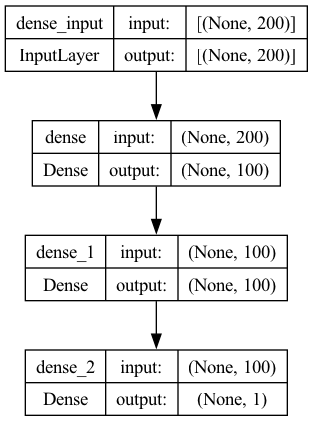

In [31]:
from keras.utils import plot_model
plot_model(predictor, to_file='/tmp/model.png', show_shapes=True,)

NOW trying WMD 

In [32]:
from word_mover_distance import model


In [33]:
# my_model = model.WordEmbedding(model_fn="glove.6B/glove.6B.100d.txt")
# wmdistance=[]
# for row in test_data:
#     s1 = row['sentence1'].lower().split()

#     s2 = row['sentence2'].lower().split()

#     wmdistance.append( my_model.wmdistance(s1, s2))

In [34]:
# for i in range(len(wmdistance)):
#     print(i+1, wmdistance[i], test_to_predict[i])

NameError: name 'wmdistance' is not defined

In [36]:
my_model = model.WordEmbedding(model_fn="glove.6B/glove.6B.100d.txt")
wmdistance=[]
for row in train_data:
    s1 = row['sentence1'].lower().split()

    s2 = row['sentence2'].lower().split()

    wmdistance.append( my_model.wmdistance(s1, s2))

In [46]:
gg = wmdistance.copy()

s = 0.33 # Threshold
for i in range(len(wmdistance)):
    if(wmdistance[i]>s):
        gg[i] = 1
    else: gg[i] = 0
print(gg.count(0))
print(list(col_to_predict).count(0))

13904
27572


In [48]:
wmdistance=[]
for row in test_data:
    s1 = row['sentence1'].lower().split()

    s2 = row['sentence2'].lower().split()

    wmdistance.append( my_model.wmdistance(s1, s2))

In [50]:
gg = wmdistance.copy()
s = 0.33 # Threshold
for i in range(len(wmdistance)):
    if(wmdistance[i]>s):
        gg[i] = 1
    else: gg[i] = 0
print(gg.count(0))
print(list(test_to_predict).count(0))

2362
4464


In [51]:
cnt = 0
for i in range(len(wmdistance)):
    if(gg[i]==test_to_predict[i]):
        cnt+=1
cnt/len(list(test_to_predict))

0.493